2025-10-22 13:07:32.307098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761138452.696478      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761138452.816602      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Random Seed being used: 42
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Total images: 4217


I0000 00:00:1761138477.118748      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761138477.119489      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model loaded successfully.


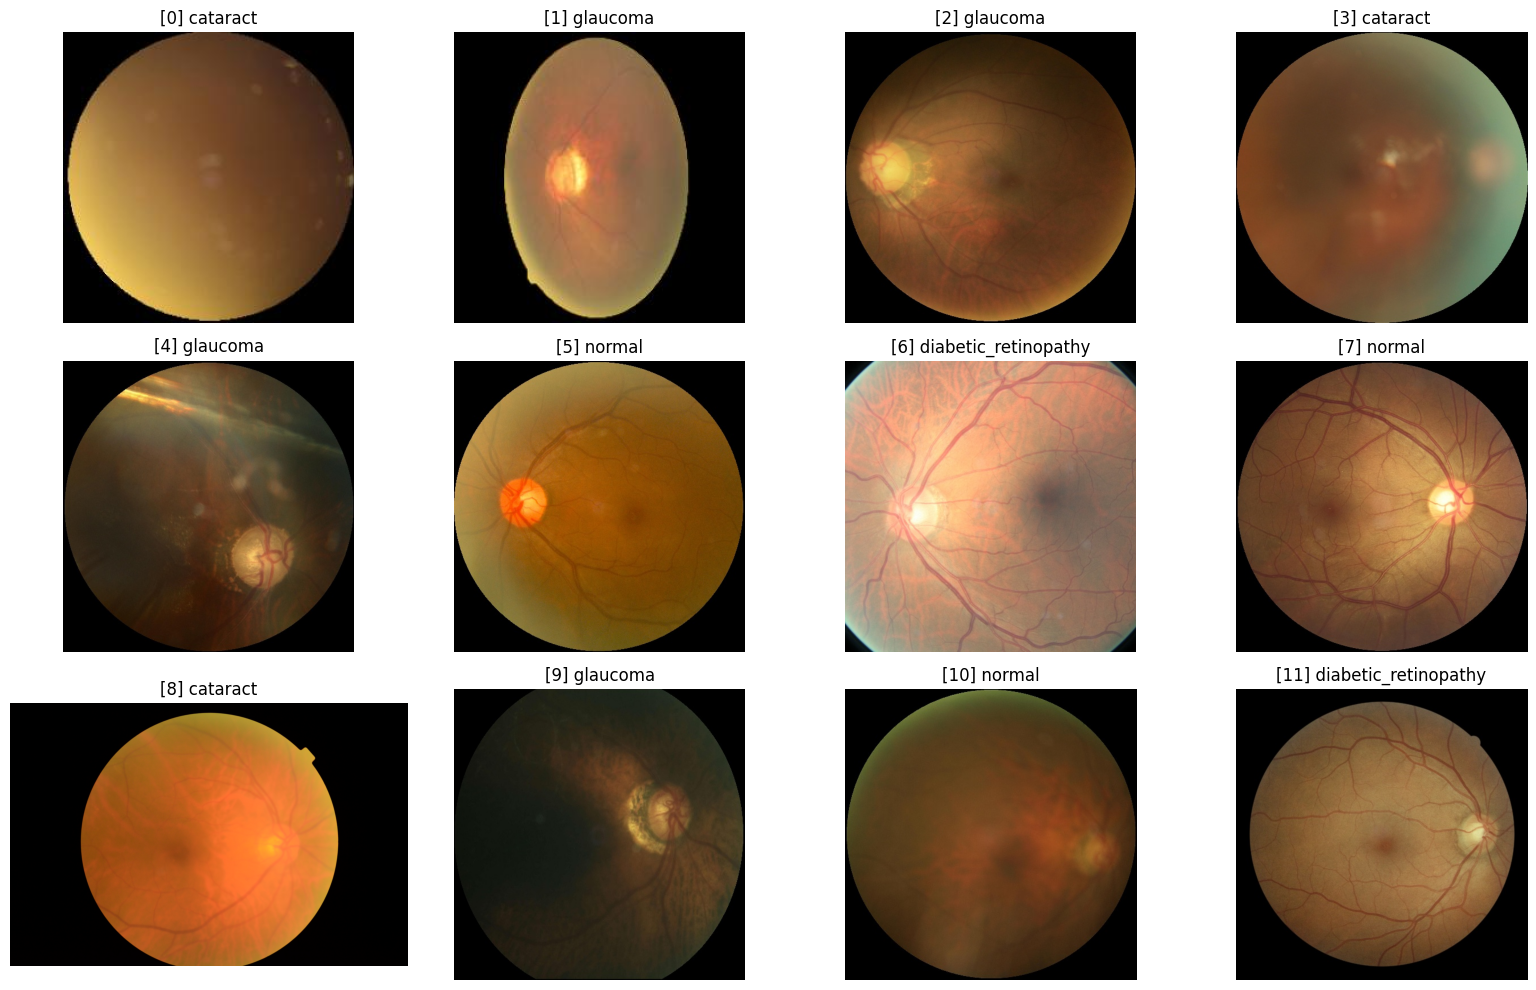

Enter image index (0-11) to test, or 'n' for new grid, or 'q' to quit:  3


I0000 00:00:1761138617.579145      98 service.cc:148] XLA service 0x7b37780039c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761138617.581066      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761138617.581087      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761138618.925575      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761138621.295297      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761138621.437570      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761138621.571729      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

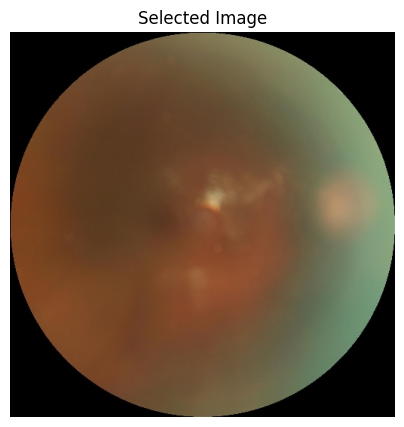

True Label : cataract
Predicted  : cataract
Confidence : 97.36%
Probabilities: {'cataract': 97.36, 'diabetic_retinopathy': 0.14, 'glaucoma': 1.37, 'normal': 1.14}
✅ Correct!



In [ ]:
# ===================================================
# Interactive Demo: Test pre-trained model on samples
# ===================================================
import os, random, numpy as np, cv2, matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import albumentations as A

# ---------------------------
# CONFIG
# ---------------------------
DATA_DIR = "/kaggle/input/eye-diseases-classification/dataset"
MODEL_PATH = "/kaggle/input/avi_96/tensorflow2/default/1/best_model.h5"
IMG_SIZE = (380,380)
TTA_ROUNDS = 3

# ---------------------------
# Seeds
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Random Seed being used:", SEED)

# ---------------------------
# Custom SEBlock Layer
# ---------------------------
class SEBlock(layers.Layer):
    def __init__(self, se_ratio=0.25, **kwargs):
        super().__init__(**kwargs)
        self.se_ratio = se_ratio
    def build(self, input_shape):
        channels = int(input_shape[-1])
        reduced = max(1, int(channels * self.se_ratio))
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(reduced, activation="relu", kernel_initializer="he_normal")
        self.fc2 = layers.Dense(channels, activation="sigmoid", kernel_initializer="he_normal")
        self.reshape = layers.Reshape((1,1,channels))
    def call(self, x):
        se = self.gap(x)
        se = self.fc1(se)
        se = self.fc2(se)
        se = self.reshape(se)
        return x * se

# ---------------------------
# Preprocessor (CLAHE + Normalize)
# ---------------------------
class Preprocessor:
    def __init__(self, img_size=(380,380), use_clahe=True):
        self.img_size = img_size
        self.use_clahe = use_clahe
        if use_clahe:
            try:
                self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            except:
                self.clahe = None
        self.val_aug = A.Compose([
            A.Resize(img_size[0], img_size[1]),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
        ])
        self.tta_aug = A.Compose([
            A.Resize(img_size[0], img_size[1]),
            A.RandomRotate90(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
        ])
    def apply_clahe(self, img):
        if not self.use_clahe or self.clahe is None:
            return img
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = self.clahe.apply(lab[:,:,0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    def preprocess(self, path, training=False):
        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.apply_clahe(img)
        aug = self.tta_aug if training else self.val_aug
        out = aug(image=img)['image'].astype(np.float32)
        return out

# ---------------------------
# Load dataset (folder per class)
# ---------------------------
def load_filepaths_labels(root):
    root = Path(root)
    class_dirs = sorted([d for d in root.iterdir() if d.is_dir()])
    classes = [p.name for p in class_dirs]
    filepaths, labels = [], []
    for idx, dirp in enumerate(class_dirs):
        for p in dirp.glob("*"):
            if p.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"):
                filepaths.append(str(p))
                labels.append(idx)
    return filepaths, labels, classes

filepaths, labels, classes = load_filepaths_labels(DATA_DIR)
NUM_CLASSES = len(classes)
print("Classes:", classes)
print("Total images:", len(filepaths))

# ---------------------------
# Load model
# ---------------------------
model = keras.models.load_model(MODEL_PATH, compile=False, custom_objects={"SEBlock": SEBlock})
print("Model loaded successfully.")

# ---------------------------
# Prediction function (with TTA)
# ---------------------------
prep = Preprocessor(IMG_SIZE, use_clahe=True)

def predict_one(img_path, tta_rounds=1):
    preds = []
    for t in range(tta_rounds):
        x = prep.preprocess(img_path, training=(t>0))
        x = np.expand_dims(x, 0)
        p = model.predict(x, verbose=0)
        preds.append(p)
    p_mean = np.mean(preds, axis=0)[0]
    idx = int(np.argmax(p_mean))
    return idx, float(np.max(p_mean)), p_mean

# ---------------------------
# Function to display random grid
# ---------------------------
def display_grid_and_pick():
    N = 12
    sample_indices = random.sample(range(len(filepaths)), k=min(N, len(filepaths)))
    sample_paths = [filepaths[i] for i in sample_indices]
    sample_labels = [labels[i] for i in sample_indices]

    rows, cols = 3, 4
    plt.figure(figsize=(16,10))
    for i, (p, lab) in enumerate(zip(sample_paths, sample_labels)):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"[{i}] {classes[lab]}")
    plt.tight_layout(); plt.show()

    return sample_paths, sample_labels

# ---------------------------
# Main interactive loop
# ---------------------------
while True:
    # Step 1: Show random grid
    sample_paths, sample_labels = display_grid_and_pick()

    while True:
        choice = input(f"Enter image index (0-{len(sample_paths)-1}) to test, or 'n' for new grid, or 'q' to quit: ").strip().lower()

        if choice == 'q':
            print("Exiting demo.")
            raise SystemExit  # or break all loops

        if choice == 'n':
            # Break inner loop -> generate new grid
            break

        # Otherwise, expect a number
        try:
            idx = int(choice)
            if 0 <= idx < len(sample_paths):
                path = sample_paths[idx]
                true_lab = sample_labels[idx]
                
                # Predict
                pred_idx, conf, prob_vec = predict_one(path, tta_rounds=TTA_ROUNDS)

                # Show image & result
                img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(5,5))
                plt.imshow(img)
                plt.axis('off')
                plt.title("Selected Image")
                plt.show()

                print(f"True Label : {classes[true_lab]}")
                print(f"Predicted  : {classes[pred_idx]}")
                print(f"Confidence : {conf*100:.2f}%")
                print("Probabilities:", {c: round(float(p)*100,2) for c,p in zip(classes, prob_vec)})

                if pred_idx == true_lab:
                    print("✅ Correct!\n")
                else:
                    print("❌ Incorrect.\n")

            else:
                print("Invalid index.")
        except ValueError:
            print("Please enter a valid integer index, 'n' or 'q'.")
